# Παρατηρήσεις Doppler (Range-Rate) με το DORIS

In [1]:
# import dsoclasses
import datetime
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
# import modules for plotting ...
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Θα χρειστούμε ένα αρχείο (DORIS) RINEX καθώς και την τροχιά του δορυφόρου σε format sp3 (για τον ίδιο δορυφόρο, που να καλύπτει την περίοδο των παρατηρήσεων).

In [2]:
drinex = "../data/s6arx24001.001"
dsp3 = "../data/ssas6a20.b23357.e24001.DG_.sp3.001"

Θα χρειστούμε την θέση και ταχύτητα του δορυφόρου (διάνυσμα κατάστασης ή state vector) για τις εποχές των παρατηρήσεων. Θα πρέπει λοιπόν να κάνουμε παρεμβολή για να τις υπολογίσουμε, με βάσει τα στοιχεία που παρατίθενται στο αρχείο sp3. Για τον σκοπό αυτό, θα φτιάξουμε ένα αντικείμενο τύπου `OrbitInterpolator`.

In [3]:
sp3 = sp3c.Sp3(dsp3)
# set the id of the satellite we need; it should be the first (and only) satellite in the sp3 list
satid = sp3.sat_ids[0]
# extract its data
sp3_data = sp3.get_satellite(satid, True)
# construct an Interpolator
intrp = interpolator.OrbitInterpolator(satid, sp3_data, 1800, 12, 'CubicSpline')

In [4]:
# DORIS RINEX instance
rnx = DorisRinex(drinex)

# Διαλέγουμε τον σταθμό επιλογής
diob = 'D31'

## Εξαγωγή παρατηρήσεων φάσης (L1) από τον σταθμό επιλογής

In [5]:
# αποθήκευση παρατηρησεων
t = []; L1 = [];

for block in rnx:
    for beacon, data in block:
        if beacon == diob:
            t.append(block.t())
            L1.append(data['L1']['value'])

Γραφική απεικόνιση των παρατηρήσεων φάσης

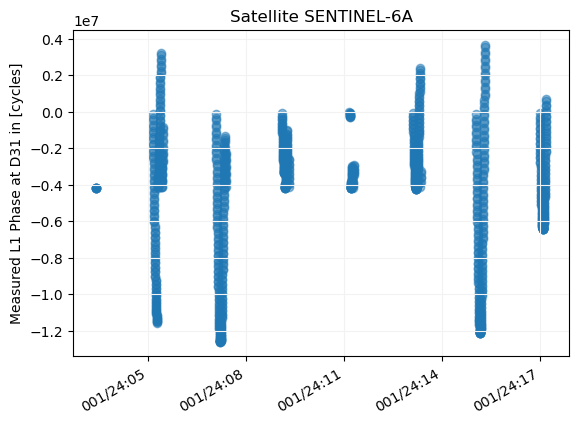

In [6]:
# create a scatterplot of extracted L1 values w.r.t. time
fig, ax = plt.subplots()
ax.scatter([at2pt(ti) for ti in t], L1, alpha=0.5)
ax.grid(color='0.95')
plt.ylabel("Measured L1 Phase at {:} in [cycles]".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Εξαγωγή παρατηρήσεων Doppler (L1) από τον σταθμό επιλογής

Η παρατήρηση Doppler (ή Doppler count ή range-rate) είναι ουσιαστική η διαφορά δύο διαδοχικών παρατηρήσεων φάσης, διά την (χρονική) απόσταση των παρατηρήσεων (σε sec). Μπορούμε λοιπόν να πάρουμε το Doppler count από τις παρατηρήσεις φάσης που εξηγάγαμε παραπάνω.

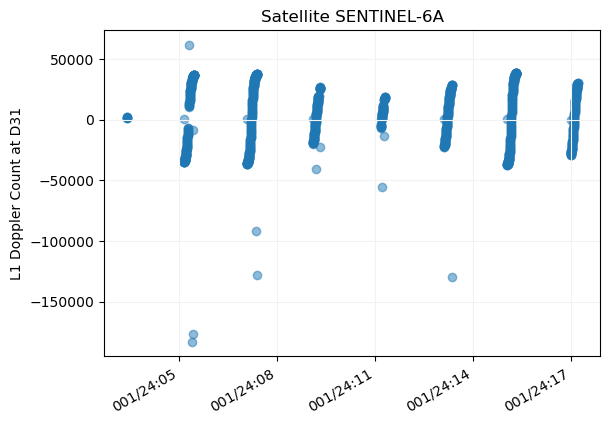

In [7]:
Ndop = []; tn = [];
for idx, ti in enumerate(t[0:-1]):
    Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
    tn.append(t[idx+1])

fig, ax = plt.subplots()
plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5)
ax.grid(color='0.95')
plt.ylabel("L1 Doppler Count at {:}".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

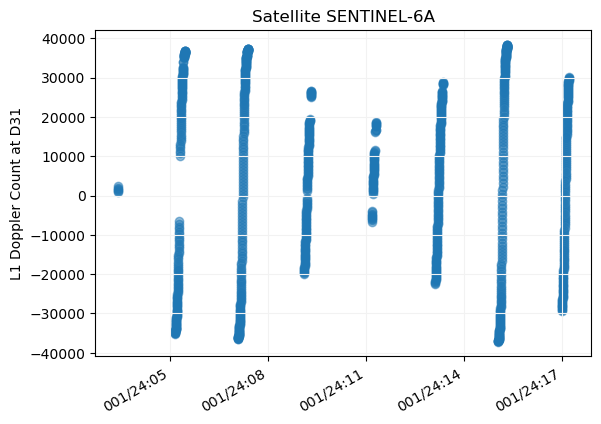

In [8]:
# μπορούμε συνήθως εύκολα να απαλλαγούμε από τα χονδροειδή (cycle-slips) ...
Ndop = []; tn = [];
for idx, ti in enumerate(t[0:-1]):
    if (t[idx+1] - t[idx]).total_seconds() < 10.:
        Ndop.append((L1[idx+1] - L1[idx]) / float((t[idx+1] - t[idx]).total_seconds()))
        tn.append(t[idx+1])

fig, ax = plt.subplots()
plt.scatter([at2pt(ti) for ti in tn], Ndop, alpha=0.5)
ax.grid(color='0.95')
plt.ylabel("L1 Doppler Count at {:}".format(diob))
plt.title("Satellite {:}".format(rnx.sat_name))
hours = mdates.HourLocator(interval = 3)
h_fmt = mdates.DateFormatter('%j/%y:%H')
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)
fig.autofmt_xdate()
plt.show()

## Skyplot - Τι δείχνει το Doopler Count ?

Θα κατασκευάσουμε το skyplot του δορυφόρου, όπως φαίνεται από τον σταθμό επιλογής. Οι προσεγγιστικές συν/νες του σταθμού, είναι:

In [9]:
DIOB_xyz = [4595220.016, 2039434.081, 3912626.007]

Μετατρέπουμε τις συν/νες σε ελλειψοειδής, και δημιουργούμε τον πίνακα στροφής (καρτεσιανές σε τοποκεντρικές) με κέντρο τον σταθμό.

In [10]:
lat, lon, hgt = transformations.car2ell(*DIOB_xyz)
Rt = transformations.geodetic2lvlh(lat, lon)
R = Rt.transpose()

Το διάστημα που μας ενδιαφέρει, φαίνεται να περιέχει τουλάχιστον οκτώ "περάσματα" (arcs) του δορυφόρου. Θα χρησιμοποιήσουμε διαφορετικά χρώματα για το καθένα:

In [11]:
c=['red','green','blue','black','orange', 'olive', 'pink', 'purple', 'brown', 'gray']

Θα αποθηκεύσουμε επίσης τα entry points του δορυφόρου, δλδ τις χρονικές στιγμές που εμφανίζεται στον ορίζοντα.

In [12]:
entries_az = []; entries_el = []; entries_t = [];
last_elevation_was = -np.pi

Για το skyplot, χρειαζόμαστε τα στοιχεία του sp3 (όχι του RINEX) και δεν χρειαζόμαστε παρεμβολή.

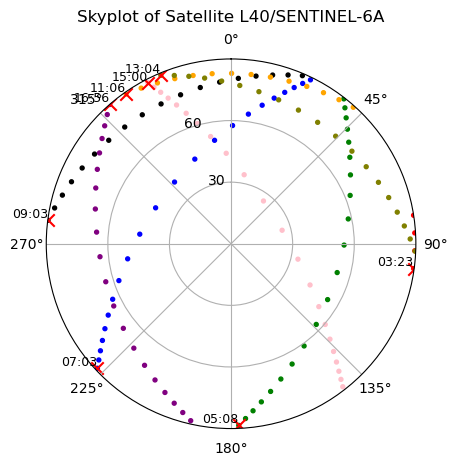

In [13]:
# data to plot (different colors for each pass)
azs = []; els = []; colors = [];
# entr points (of each pass)
color_idx = -1

# για κάθε θέση/εποχή που έχουμε στο sp3 ...
for k,v in sp3_data.items():
    # θα χρησιμοποιήσουμε μόνο εποχές σχετικές με την ημέρα ενδιαφέροντος ...
    if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
        # καρτεσιανές διαφορές (διάνυσμα σταθμού-δορυφόρου)
        dx = v['x'] - DIOB_xyz[0]
        dy = v['y'] - DIOB_xyz[1]
        dz = v['z'] - DIOB_xyz[2]
        # μετατρέπουμε το διάνυσμα στο τοποκεντρικό σύστημα
        enu = R @ [dx, dy, dz]
        # απόσταση (range), αζιμούθιο και γωνία ύψους 
        r  = np.linalg.norm(enu)
        az = np.arctan2(enu[0], enu[1])
        el = np.arcsin(enu[2] / r)
        # χρειαζόμαστε το σημείο, μόνο αν είναι πάνω από τον ορίζοντα (elevation > 0)
        if el >= 0:
            azs.append(az)
            els.append(90e0 - np.degrees(el))
            colors.append(c[color_idx])
        # αν είναι καινούριο πέρασμα (από αρνητικό σε θετικό elevation), το σημειώνουμε
        # και θέτουμε (καινούριο) χρώμα
        if last_elevation_was <= 0 and el > 0:
            entries_az.append(az)
            entries_el.append(90e0 - np.degrees(el))
            entries_t.append(k)
            color_idx += 1
            colors[-1] = c[color_idx]
        last_elevation_was = el

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(azs, els, c=colors, s=2*4)
ax.scatter(entries_az, entries_el, marker='x', c='red', s=4*20)
# time of entry
for i in range(len(entries_t)):
    ax.text(entries_az[i], entries_el[i], entries_t[i].strftime("%H:%M"),
    fontsize=9, ha='right', va='bottom')
ax.set_rmax(90)
ax.set_rticks([30, 60])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

# Rotate the angle axis by -90 degrees (make 0 degrees point up)
ax.set_theta_zero_location('N')  # Set 0° to the top (North)
ax.set_theta_direction(-1)  # Make the angles increase clockwise

ax.set_title("Skyplot of Satellite {:}/{:}".format(satid, rnx.sat_name), va='bottom')
plt.show()

## GroundTrack - Ποιό Κομμάτι της Τροχιάς Παρακολουθούμε ?

Groundtrack είναι η απεικόνιση της τροχιάς ενός δορυφόρου σε χάρτη. Για να το δημιουργήσουμε, θα χρησιμοποιήσουμε τις θέσεις που αναγράφονται στο αρχείο sp3. Για την απεικόνιση, αρκεί να μετατρέψουμε τις καρτεσιανές σε ελλειψοειδής συν/νες και έπειτα στην προβολή που θα χρησιμοποιήσουμε.

Θα χρησιμοποιήσουμε διαφορετικό χρώμα για τα κομμάτια της τροχιάς που είναι ορατά από τον σταθμό επιλογής (όταν δλδ ο δορυφόρος είναι πάνω από τον ορίζοντα).

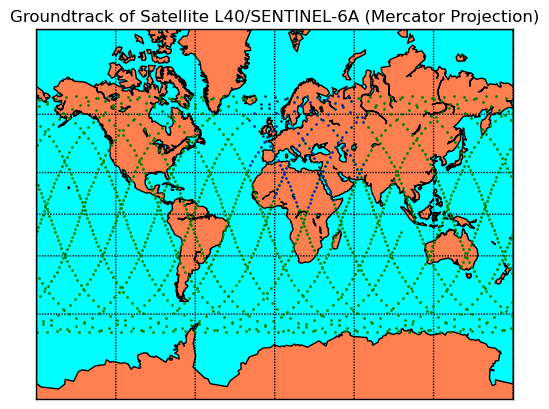

In [15]:
# groundtrack
#
from mpl_toolkits.basemap import Basemap

lons = []; lats = [];
observed_lons = []; observed_lats = [];
for k,v in sp3_data.items():
        if k >= at2pt(rnx.time_first_obs) and k<at2pt(rnx.time_first_obs)+datetime.timedelta(hours=24):
            phi, lamda, _ = transformations.car2ell(v['x'], v['y'], v['z'])
            lons.append(lamda); lats.append(phi);

            # είναι η θέση ορατή απά τον σταθμό ?
            dx = v['x'] - DIOB_xyz[0]
            dy = v['y'] - DIOB_xyz[1]
            dz = v['z'] - DIOB_xyz[2]
            enu = R @ [dx, dy, dz]
            r  = np.linalg.norm(enu)
            el = np.arcsin(enu[2] / r)
            if np.degrees(el) >= 0:
                observed_lons.append(lamda); observed_lats.append(phi);

# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
                llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# convert to map projection coords.
xpt,ypt = m(np.degrees(lons),np.degrees(lats))
m.plot(xpt,ypt,'go',linewidth=.1,markersize=1)
xpt,ypt = m(np.degrees(observed_lons),np.degrees(observed_lats))
m.plot(xpt,ypt,'bo',linewidth=.1,markersize=.5)

plt.title("Groundtrack of Satellite {:}/{:} (Mercator Projection)".format(satid, rnx.sat_name))
plt.show()